In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from srim import TRIM, Ion, Layer, Target
from srim.output import Vacancy, Collision, Ioniz, Phonons
import pandas as pd
import uproot
from tqdm import tqdm
import copy

/opt/miniconda3/envs/PythonData/lib/python3.6/site-packages/srim/core/elementdb.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(dbpath, "r"))


## Non-ionizing energy loss

(0, 0.2)

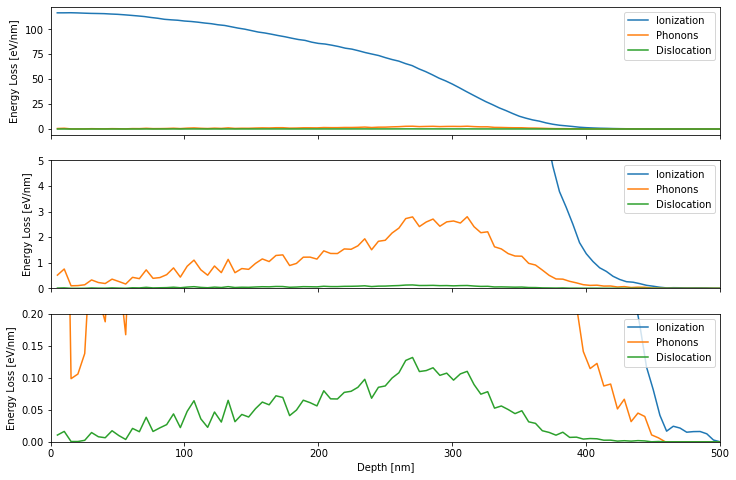

In [2]:
ioniz = Ioniz('/Users/dustincombs/Dev/srim_out')
vacancies = Vacancy('/Users/dustincombs/Dev/srim_out')
phonons = Phonons('/Users/dustincombs/Dev/srim_out')

fig, axes = plt.subplots(3,1,sharex=True,figsize=(12,8))
for ax in axes:
    ionization_total = 10*(ioniz.ions + ioniz.recoils)
    damage_total = 10*2.33*(vacancies.knock_ons + vacancies.vacancies.reshape(-1))
    phonon_total = 10*(phonons.ions + phonons.recoils)
    ax.plot(ioniz.depth/10., ionization_total, label='Ionization')
    ax.plot(phonons.depth/10., phonon_total, label='Phonons')
    ax.plot(vacancies.depth/10., damage_total, label='Dislocation')
#     ax.plot(ioniz.depth/10., ioniz.recoils*10, label='Nuclear Recoil')
    ax.set_xlim(0,500)
    ax.set_ylabel('Energy Loss [eV/nm]')
    ax.legend()
axes[-1].set_xlabel('Depth [nm]')
axes[1].set_ylim(0,5)
axes[-1].set_ylim(0,0.2)
fig.savefig('niel.png')


## NIEL distribution

In [103]:
def get_df(energy, filenums):
    fnames = [f"./pysrim/niel{energy:.1f}_{n}.csv" for n in filenums]
    dfs = [pd.read_csv(f) for f in fnames]
    df = pd.concat(dfs)
    return df

Text(0.5, 0, 'Fractional Energy Loss - Dislocations')

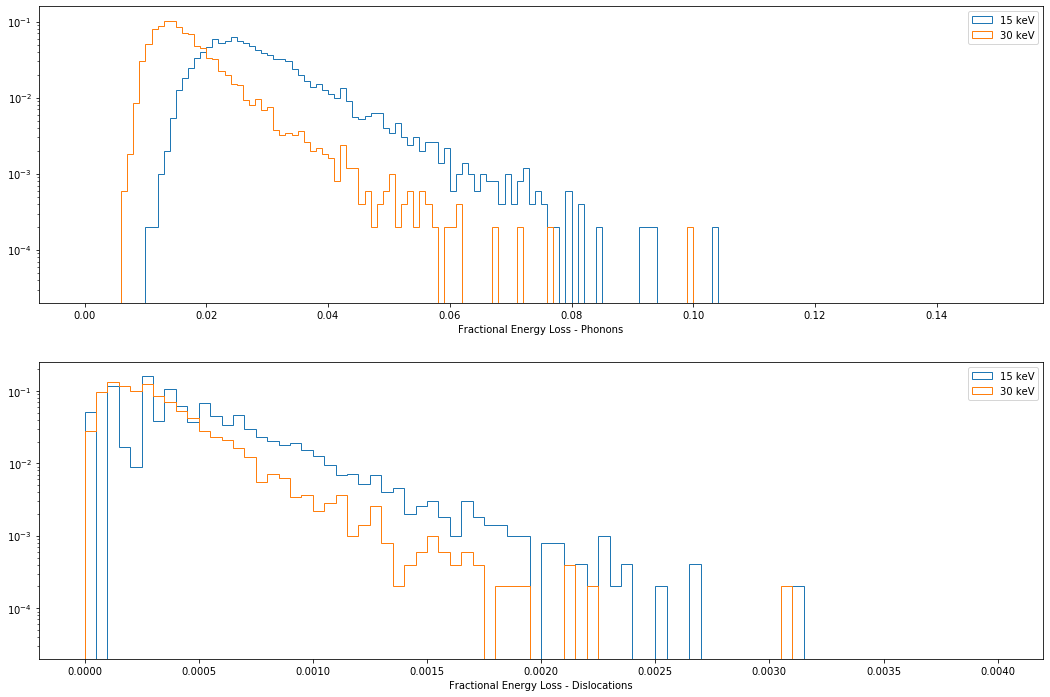

In [104]:
fig, axes = plt.subplots(2,1,sharex=False,figsize=(18,12))

nums = [0, 500,1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
df15 = get_df(15, nums)
df30 = get_df(30, nums)

dfdict = {'15 keV': df15,'30 keV': df30}

bins_p = np.linspace(0,0.15,151)
bins_d = np.linspace(0,0.004,81)
for key,df in dfdict.items():
    phonons = df['phonon']
    weights = np.ones_like(phonons)/len(phonons)
    axes[0].hist(phonons,bins=bins_p,weights=weights,histtype='step',label=key, log=True)
    damage = df[' damage']
    weights = np.ones_like(damage)/len(damage)
    axes[1].hist(damage,bins=bins_d,weights=weights,histtype='step',label=key, log=True)

axes[0].legend()
axes[0].set_xlabel('Fractional Energy Loss - Phonons')
axes[1].legend()
axes[1].set_xlabel('Fractional Energy Loss - Dislocations')
fig.savefig('loss_dist.png')

## Save SRIM output

In [ ]:
# flip z and x coordinates to be consistent with SSD
names = ['ion','energy_i','Z','Y','X','stopping_power','recoil']
df2 = pd.read_csv('/Users/dustincombs/Dev/NDP/SSD/EXYZ.txt',delim_whitespace='\t',skiprows=15,names=names)
# calculate energy deposits
df2['energy_i'] = df2['energy_i'].astype('float')
df2['E'] = -1*df2.groupby('ion')['energy_i'].diff()
df2.dropna(inplace=True)
# for some reason the last ion has an incomplete record so drop it
n_ions = df2['ion'].nunique()
df_out = df2[df2['ion']<n_ions].copy()
df_out

In [ ]:
df_out.to_hdf("~/Dev/NDP/SSD/data/exyz25kv2.hdf",key='hits',index=False)
df_out.to_csv("~/Dev/NDP/SSD/data/exyz25kv2.csv",index=False)

## Backscatter comparison

In [122]:
# read SRIM backscatter files
names = ['num','a','energy','x','y','z','cosx','cosy','cosz']
nums = [0,2,3,4]
dfs = [pd.read_csv(f'/Users/dustincombs/srim_out/BACKSCAT{n}.txt',skiprows=12,delim_whitespace='\t',names=names) for n in nums]
srimdf = pd.concat(dfs)
srimBS = len(srimdf)
srimEvents = len(nums)*1e5
srimRate = srimBS/srimEvents
print(f'SRIM backscatters: {srimBS}')
print(f'SRIM events: {srimEvents:.0f}')
print(f'SRIM backscatter rate: {srimRate}')

SRIM backscatters: 945
SRIM events: 400000
SRIM backscatter rate: 0.0023625


In [129]:
# read G4 output
file = uproot.open('/Users/dustincombs/Dev/ndpfeature/NDP/Geant4/build/p30keV_o3_500k.root')
br = file['ntuple/hits']
g4df = br.pandas.df(br.keys())
g4df

,eventID,trackID,classification,enPrimary,eDep,x,y,z,px,py,pz,time,pixelNumber,particle
entry,,,,,,,,,,,,,,
0,0,1,0,30.0,0.324964,0.000000e+00,0.000000e+00,0.000000,-0.000012,-0.000005,7.503147,4.171368,64,b'proton'
1,0,1,0,30.0,0.423391,1.127139e-07,-1.157347e-08,0.000005,0.131497,-0.067016,7.460939,4.171370,64,b'proton'
2,0,1,0,30.0,0.125749,2.902607e-07,1.484151e-08,0.000010,0.170760,0.088016,7.406480,4.171372,64,b'proton'
3,0,1,0,30.0,0.260654,5.129619e-07,1.173449e-07,0.000015,0.218673,0.123289,7.388766,4.171374,64,b'proton'
4,0,1,0,30.0,1.206175,6.335505e-07,8.761300e-08,0.000020,-0.184527,-0.271723,7.352540,4.171376,64,b'proton'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42324629,499999,1,0,30.0,0.088965,-3.941010e-06,-3.156967e-05,0.000252,-1.299199,1.549994,-0.821030,4.171564,64,b'proton'
42324630,499999,1,0,30.0,0.121497,-6.217289e-06,-2.758188e-05,0.000250,-0.316993,1.963621,-0.800781,4.171571,64,b'proton'
42324631,499999,1,0,30.0,0.019034,-6.276573e-06,-2.322531e-05,0.000248,0.050574,1.774002,-1.104494,4.171578,64,b'proton'


In [131]:
# group by event
sumdf = g4df.groupby('eventID').sum('eDep').copy()
# assume any loss is due to backscatter
g4BS = sum(sumdf['eDep']<29.8)
g4Events = len(sumdf)
g4rate = g4BS/g4Events
print(f'G4 backscatters: {g4BS}')
print(f'G4 events: {g4Events}')
print(f'G4 backscatter rate: {g4rate}')

G4 backscatters: 1685
G4 events: 500000
G4 backscatter rate: 0.00337


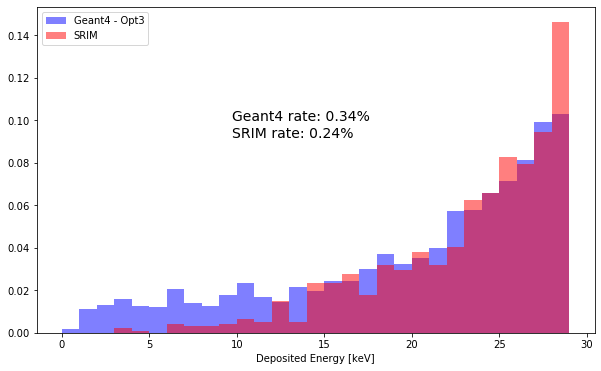

In [132]:
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(0,29,30)
g4counts = sumdf.eDep
g4weights = np.ones_like(g4counts)/nBS
ax.hist(sumdf.eDep,bins=bins,color='b',alpha=0.5,weights=g4weights,label='Geant4 - Opt3')
ax.set_xlabel('Deposited Energy [keV]')

# SRIM tracks ion energy for backscatters not deposited energy
# convert to keV and subtract
srimcounts = 30 - srimdf.energy/1e3
srimweight = np.ones_like(srimcounts)/len(srimcounts)
ax.hist(srimcounts,bins=bins,weights=srimweight,alpha=0.5,color='r',label='SRIM')

textstr = f'Geant4 rate: {g4rate*100:0.2f}%\nSRIM rate: {len(srimdf)/4000:0.2f}%'
ax.text(0.35,0.6,textstr,transform=ax.transAxes,fontsize=14)
plt.legend()
plt.savefig('bs_comparison_o3.png')

## dE/dl comparison

In [133]:
# read SRIM data
sdf = pd.read_csv('/Users/dustincombs/Dev/NDP/SSD/data/exyz25kv2.csv')
sdf['ix'] = sdf.index
sgdf = sdf.groupby('ion')
# get index of first of each group
ix_first = sgdf.first()['ix']
# get step deltas
sdf['dx'] = sgdf['X'].diff()
sdf['dy'] = sgdf['Y'].diff()
sdf['dz'] = sgdf['Z'].diff()
# for the first step dx = x
sdf['dx'] = sdf['X'].where(sdf['ix'].isin(ix_first),sdf['dx'])
sdf['dy'] = sdf['Y'].where(sdf['ix'].isin(ix_first),sdf['dy'])
sdf['dz'] = sdf['Z'].where(sdf['ix'].isin(ix_first),sdf['dz'])
# get distance
sdf['dl'] = np.sqrt(np.square(sdf['dx']) + np.square(sdf['dy']) + np.square(sdf['dz']))/10
sdf['sumdl'] = sdf.groupby('ion')['dl'].cumsum(axis=0)
stotaldl = sdf.groupby('ion').sum('dl')['dl']
sdf['dedl'] = sdf['E']/sdf['dl']*1000
sdf

,ion,energy_i,Z,Y,X,stopping_power,recoil,E,ix,dx,dy,dz,dl,sumdl,dedl
0,1,29.65300,16.312,0.017646,0.008672,11.5680,0.001323,0.34700,0,0.008672,0.017646,16.312,1.631201,1.631201,212.726672
1,1,29.40000,38.060,0.058116,-0.001693,11.5410,0.001526,0.25300,1,-0.010366,0.040470,21.748,2.174804,3.806005,116.332322
2,1,29.05700,62.527,0.223520,0.023013,11.5040,0.000535,0.34300,2,0.024706,0.165404,24.467,2.446757,6.252762,140.185551
3,1,28.78000,81.556,0.404410,0.090745,11.4730,0.005916,0.27700,3,0.067732,0.180890,19.029,1.902998,8.155760,145.559793
4,1,28.45100,122.330,0.698770,0.315620,11.4360,0.039104,0.32900,4,0.224875,0.294360,40.774,4.077568,12.233329,80.685345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494878,24999,1.08700,1825.200,-1500.400000,1825.700000,2.5645,108.670000,0.39870,2494878,60.700000,-61.800000,-52.400,10.123976,382.594567,39.381759
2494879,24999,0.89247,1791.400,-1484.800000,1884.700000,2.3237,0.002964,0.19453,2494879,59.000000,15.600000,-33.800,6.976245,389.570813,27.884627
2494880,24999,0.59179,1733.800,-1409.200000,1869.500000,1.8922,0.390630,0.30068,2494880,-15.200000,75.600000,-57.600,9.625051,399.195863,31.239316
2494881,24999,0.29845,1726.900,-1327.400000,1955.000000,1.3438,0.010205,0.29334,2494881,85.500000,81.800000,-6.900,11.852890,411.048753,24.748395


In [134]:
# read G4 data

# file = uproot.open('/Users/dustincombs/Dev/ndpfeature/NDP/Geant4/build/p30keV_pen_limit.root')
# file = uproot.open('/Users/dustincombs/Dev/ndpfeature/NDP/Geant4/build/p30keV_liv_limit.root')
file = uproot.open('/Users/dustincombs/Dev/ndpfeature/NDP/Geant4/build/p30keV_opt3_limit.root')
# file = uproot.open('/Users/dustincombs/Dev/ndpfeature/NDP/Geant4/build/p30keV_gs_limit.root')
# file = uproot.open('/Users/dustincombs/Dev/ndpfeature/NDP/Geant4/build/p30keV_ss_limit.root')

br = file['ntuple/hits']
g4df = br.pandas.df(br.keys())
g4df

,eventID,trackID,classification,enPrimary,eDep,x,y,z,px,py,pz,time,pixelNumber,particle
entry,,,,,,,,,,,,,,
0,0,1,0,30.0,0.324964,0.000000e+00,0.000000e+00,0.000000,-0.000012,-0.000005,7.503147,4.171368,64,b'proton'
1,0,1,0,30.0,0.423391,1.127139e-07,-1.157347e-08,0.000005,0.131497,-0.067016,7.460939,4.171370,64,b'proton'
2,0,1,0,30.0,0.125749,2.902607e-07,1.484151e-08,0.000010,0.170760,0.088016,7.406480,4.171372,64,b'proton'
3,0,1,0,30.0,0.260654,5.129619e-07,1.173449e-07,0.000015,0.218673,0.123289,7.388766,4.171374,64,b'proton'
4,0,1,0,30.0,1.206175,6.335505e-07,8.761300e-08,0.000020,-0.184527,-0.271723,7.352540,4.171376,64,b'proton'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319669,49999,1,0,30.0,0.016193,4.027460e-05,-4.195570e-05,0.000290,-0.434693,0.900423,-0.479940,4.171827,64,b'proton'
4319670,49999,1,0,30.0,0.014909,3.858861e-05,-3.846335e-05,0.000288,-1.046312,-0.035142,-0.321979,4.171839,64,b'proton'
4319671,49999,1,0,30.0,0.072232,3.449496e-05,-3.860085e-05,0.000287,-0.897594,-0.473173,0.377002,4.171851,64,b'proton'


In [135]:
gdf = g4df.groupby('eventID')
g4df['dx'] = gdf['x'].diff()
g4df['dy'] = gdf['y'].diff()
g4df['dz'] = gdf['z'].diff()
# find the distance and convert to nm
g4df['dl'] = np.sqrt(np.square(g4df['dx']) + np.square(g4df['dy']) + np.square(g4df['dz']))*1e6
g4df.dropna(inplace=True)
# calculate de/dl and convert to eV/nm
g4df['dedl']=g4df['eDep']/g4df['dl']*1000
# get cumulative length
g4df['sumdl']=g4df.groupby('eventID')['dl'].cumsum(axis=0)


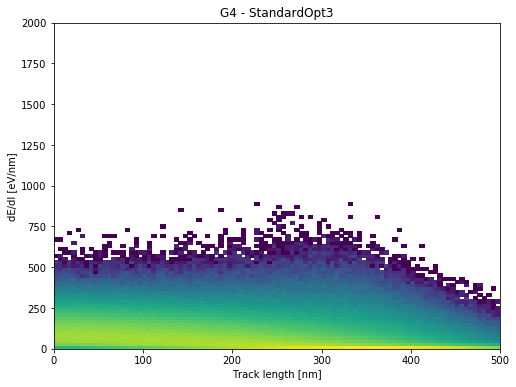

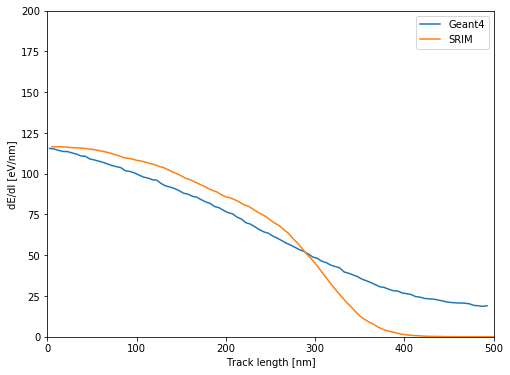

In [138]:
fig, ax = plt.subplots(figsize=(8,6))
# set bin edges
zbins = np.linspace(0,500,101)
ebins = np.linspace(0,2000,101)

# draw 2d histogram
h,xedges,yedges,img = ax.hist2d(g4df.sumdl,g4df.dedl,bins=[zbins,ebins],norm = mpl.colors.LogNorm())
# h,xedges,yedges,img = ax.hist2d(sdf.sumdl,sdf.dedl,bins=[zbins,ebins],norm = mpl.colors.LogNorm())
ax.set_xlabel('Track length [nm]')
ax.set_ylabel('dE/dl [eV/nm]')
ax.set_title('G4 - StandardOpt3')
ax.set_ylim(0,2000)
ecenters = (ebins[:-1]+ebins[1:])/2
zcenters = (zbins[:-1]+zbins[1:])/2
averages = []

# average along vertical slices of the 2d hist
for i in h:
    averages.append(sum(i*ecenters)/sum(i))

o3 = copy.deepcopy(averages)   

fig, ax = plt.subplots(figsize=(8,6))
ends = -1
ax.plot(zcenters[:ends],averages[:ends],label="Geant4")
ax.set_ylim(0,200)
ax.set_xlim(0,500)
ax.set_xlabel('Track length [nm]')
ax.set_ylabel('dE/dl [eV/nm]')

ionization_total = 10*(ioniz.ions + ioniz.recoils)
ax.plot(ioniz.depth/10., ionization_total, label='SRIM')
ax.legend()


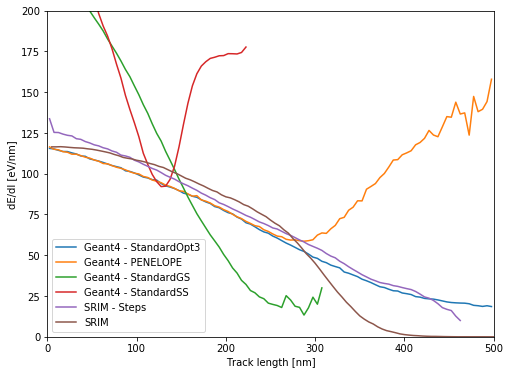

In [139]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(zcenters,o3,label="Geant4 - StandardOpt3")
ax.plot(zcenters,pen,label="Geant4 - PENELOPE")
ax.plot(zcenters,gs,label="Geant4 - StandardGS")
ax.plot(zcenters,ss,label="Geant4 - StandardSS")
ax.plot(zcenters,srimsteps,label="SRIM - Steps")
ax.set_ylim(0,200)
ax.set_xlim(0,500)
ax.set_xlabel('Track length [nm]')
ax.set_ylabel('dE/dl [eV/nm]')

ionization_total = 10*(ioniz.ions + ioniz.recoils)
ax.plot(ioniz.depth/10., ionization_total, label='SRIM')
ax.legend()

## Range comparison

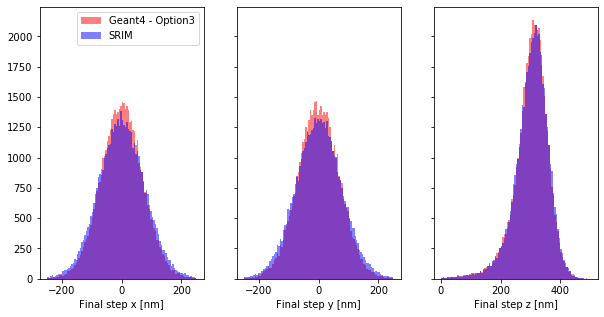

In [91]:
# read SRIM data
names = ['ion','z','y','x']
rangedf = pd.read_csv(f'/Users/dustincombs/Dev/srim_out/RANGE_3D.txt',skiprows=16,delim_whitespace='\t',names=names)
# define bins for x,y
# use zbins from before
bins = np.linspace(-250,250,101)
zstop = rangedf['z']/10
ystop = rangedf['y']/10
xstop = rangedf['x']/10

fig, axes = plt.subplots(1,3,figsize=(10,5),sharey=True)
axes[0].hist(xstop,bins=bins,alpha=0.5,color='r',label='Geant4 - Option3')
axes[1].hist(ystop,bins=bins,alpha=0.5,color='r',label='Geant4')
axes[2].hist(zstop,bins=zbins,alpha=0.5,color='r',label='Geant4')

xg4 = g4df.groupby('eventID').last()['x']*1e6
yg4 = g4df.groupby('eventID').last()['y']*1e6
zg4 = g4df.groupby('eventID').last()['z']*1e6

axes[0].hist(xg4,bins=bins,alpha=0.5,color='b',label='SRIM')
axes[1].hist(yg4,bins=bins,alpha=0.5,color='b')
axes[2].hist(zg4,bins=zbins,alpha=0.5,color='b')

axes[0].legend()
axes[0].set_xlabel('Final step x [nm]')
axes[1].set_xlabel('Final step y [nm]')
axes[2].set_xlabel('Final step z [nm]')
fig.savefig('range_comparison_o3.png')